If you are running this locally, please make sure you have Cuda Enabled, and Tensorflow 2.x and Pytorch 1.x installed with GPu support. 

You can also try this notebook on Google colab :
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IhabBendidi/sentiment_embeddings/blob/main/sentiment_embeddings.ipynb)

Whether locally or on Colab, if it's the first time running this notebook, run the following command to install all necessary dependencies (Pytorch and Tensorflow must be installed manually).

In [ ]:
!pip3 install -r requirements.txt

# Sentiment Analysis performance benchmark

**Authors :** *Ihab Bendidi*, *Yousra Bourkiche*, *Clément Siegrist*, *Kaouter Berrahal* 

In general, documents with similar sentiments, would be close to each other in the embeddings feature space. This can become another method to judge the performance of sentiment analysis models.

In this work, we aim to perform a benchmark of recent sentiment analysis works and models, reproduce their results, and judge their performance in comparison to baseline methods.

This work has the following plan :

**I - Processing & Exploratory Data Analysis**
- *Understanding the data*
- *Text Preprocessing*

Throughout this project, we are working with a clean Ubuntu 20.04 distribution, on Python 3.7. We are going to use libraries such as Pytorch 1.8 and Tensorflow 2, which would be using GPU. For installation of dependencis, you can install them using the `requirements.txt` file. More details can be found in the `README.md` file. You can find below the specs of the GPU we have been using for our experiments.

In [1]:
!nvidia-smi

Tue Dec  8 05:20:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060    On   | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P0    28W /  N/A |    527MiB /  6078MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### I - Processing & Exploratory Data Analysis

#### 1 - Understanding the data

We would be working throughout this experiment on a Twitter dataset of complains and reviews of people about airline companies. These reviews got a sentiment already labelled, even though its apparent it was also generated with another model. This might incur incorrect labels, but as long as the models we use are trained on the same dataset, it would still fit our comparison purpose, even though it won't have much use in production. While this dataset is limiting, especially in terms of size, it would also be a good baseline to start our work with.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader

We import out dataset in the form of a `.csv` file to put it in a Pandas Dataframe.

In [3]:
df = pd.read_csv('tweets.csv')

In [4]:
# The size of our dataset
df.shape

(14640, 15)

As we explore the values of our dataset, we notice that much of the data is not pertinent for our task. As most of the data is for airlines to know the general opinions about their services. The most interesting columns for us are `airline_sentiment`, and the `text` columns.

In [5]:
# Show the first five values of our dataframe
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
# importing the interesting & pertinent data in our dataset into a new dataframe
tweets = df[['tweet_id','text','airline_sentiment','airline_sentiment_confidence']]
tweets.head()

,tweet_id,text,airline_sentiment,airline_sentiment_confidence
0,570306133677760513,@VirginAmerica What @dhepburn said.,neutral,1.0000
1,570301130888122368,@VirginAmerica plus you've added commercials t...,positive,0.3486
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...,neutral,0.6837
3,570301031407624196,@VirginAmerica it's really aggressive to blast...,negative,1.0000
4,570300817074462722,@VirginAmerica and it's a really big bad thing...,negative,1.0000


To explore our data further, it is a must to check whether there are missing values. Though as seen below, it appears there is none in the data that matters.

In [7]:
# The count of null or nan values in the dataset
tweets.isnull().sum()

tweet_id                        0
text                            0
airline_sentiment               0
airline_sentiment_confidence    0
dtype: int64

Our next focus would be to know the existing categories in the sentiment labels in `airline_sentiment`. We would then create a plot of their occurence in our data.

In [8]:
# Unique values in a Series of the dataframe
tweets['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

<AxesSubplot:xlabel='airline_sentiment'>

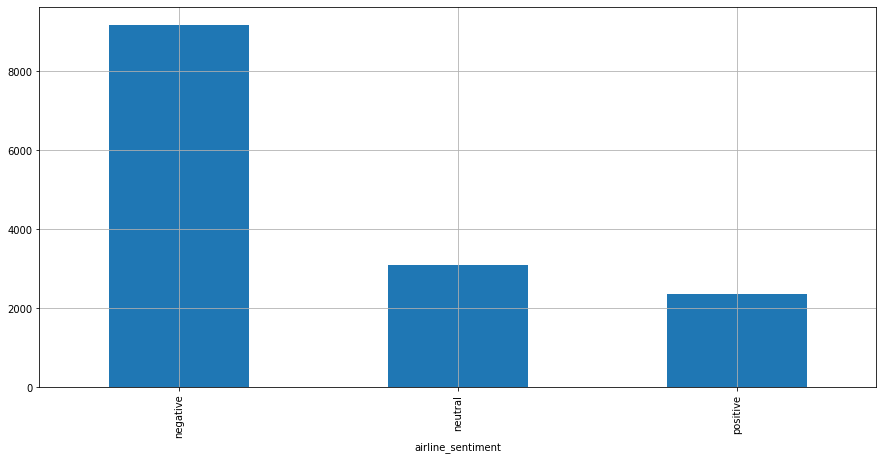

In [9]:
tweets.groupby('airline_sentiment')['tweet_id'].count().plot.bar(figsize=(15,7),grid=True)

As it appears, our data is heavily imbalanced, as the `negative` category got up three times more occurences than the `neutral` or `positive` category. This is a matter that would need to be taken into account when judging the model performance, to avoid any bias in its predictions.

On another note, we take a peak at the format of the tweets and texts we'll be handling below.

In [10]:
print(tweets['text'][1000])

@united how can you not put my bag on plane to Seattle. Flight 1212. Waiting  in line to talk to someone about my bag. Status should matter.


#### 2 - Text preprocessing

In this part, we'll be handling the text data, cleaning it from discrepancies, and preparing it to be in a format that is friendly to processing by our models, that would come further on the line.

We can notice in the following tweets, and through other careful explorations of the dataset, that airline company names are often tagged at the beginning of every tweet.

In [11]:
print(tweets['text'][10])
print(tweets['text'][1000])

@VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24
@united how can you not put my bag on plane to Seattle. Flight 1212. Waiting  in line to talk to someone about my bag. Status should matter.


While this appears harmless, we could also forward a hypothesis that our models, further down the line, might overfit and learn to map company names tagged in the tweet directly to a sentiment category. That would be especially possible of some company names got some specific categories of sentiment review much more often than others.

To make certain of whether this hypothesis is unfounded or not, we search here for the occurences of the different categories of sentiments for each company name tagged.

To achieve that, we start by extracting the tags from every tweet.

In [12]:
# This helper function returns the tags appearing mostly at the beginning of each tweet
def get_tags(row):
    splits = row['text'].split(' ')
    # Some simple text processing to have all tags in the same format
    row['tags'] = ''.join(e for e in splits[0] if e.isalnum()).lower()   
    # Correcting a very common typo
    if row['tags'] == 'jetblue':
        row['tags'] = 'jetblues'
    return row

# Extracting the tags (without deletion) from the tweets into their own columns
df = tweets.apply(get_tags,axis=1)

Our dataframe has a new Series inside, of the tags of the companies occuring in the tweets, in an unified format.

In [13]:
df.head()

,tweet_id,text,airline_sentiment,airline_sentiment_confidence,tags
0,570306133677760513,@VirginAmerica What @dhepburn said.,neutral,1.0000,virginamerica
1,570301130888122368,@VirginAmerica plus you've added commercials t...,positive,0.3486,virginamerica
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...,neutral,0.6837,virginamerica
3,570301031407624196,@VirginAmerica it's really aggressive to blast...,negative,1.0000,virginamerica
4,570300817074462722,@VirginAmerica and it's a really big bad thing...,negative,1.0000,virginamerica


Our next task would be to group the tags and sentiment categories together, to be able to count the occurences of each category in each tag.

In [14]:
# Defining a helper function to count the occurences of each category of sentiment for each tag
def count_tags(df, col, new_col):
    df[new_col] = df[col].count()
    return df

# Grouping all tags and sentiment categories together, in order to count occurences of categories 
# of sentiments for each category, then saving the resulting Series into our DataFrame
df['tag_count'] = df.groupby(['tags','airline_sentiment']).apply(count_tags,'tweet_id','count')['count']

While this would enable us to have the exact count of occurences of each category of sentiment for each tag, we would find that there is some noise in our data. We would be filtering that noise by only keeping the tags whose count is beyond 15. The number of the filtered tags is negligible.

In [15]:
temp_df = df[df['tag_count']>15].copy()

Following that, we create a cross table of the values of the count of occurences for each sentiment category, for each company tag, then we plot a bar plot to visualize the differences between the occurences.

<AxesSubplot:xlabel='tags'>

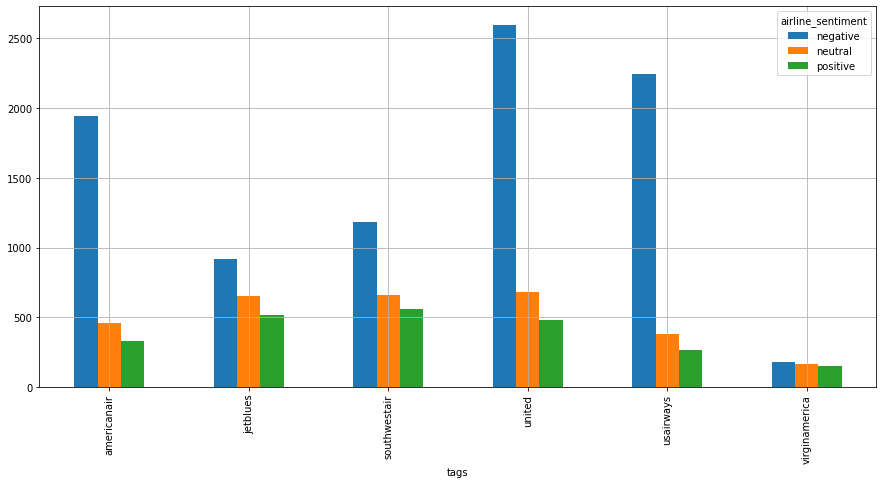

In [16]:
# Create a cross table of the count of the occurences of tags/sentiment classes
cross_df = pd.crosstab(temp_df.tags,temp_df.airline_sentiment,values=temp_df['tag_count'],
                       margins=False,aggfunc='mean')

# Visualize our results in a bar plot
cross_df.plot.bar(figsize=(15,7),grid=True)

The earlier results in the plot have proven our hypothesis right : Some company tags got a very large ratio of negative sentiments. We believe these tags might make the model learn to map the presence of the tags to a sentiment category, mostly the `negative` category, as it is the major category for the tags `americanair`, `united` and `usairways`.

Our next task would involve deleting them from our tweets, to handle the text without bias.

In [17]:
# A helper function that would remove the tags from the text and save it into a new column
def remove_tags(row):
    splits = row['text'].split(' ')
    row['processed_text'] = ' '.join(splits[1:])
    return row

# Removing the tags from the text and saving the cleaned up text in a new column
tweets = df.apply(remove_tags,axis=1)[['tweet_id','text','processed_text','airline_sentiment']]

tweets.head()

,tweet_id,text,processed_text,airline_sentiment
0,570306133677760513,@VirginAmerica What @dhepburn said.,What @dhepburn said.,neutral
1,570301130888122368,@VirginAmerica plus you've added commercials t...,plus you've added commercials to the experienc...,positive
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...,I didn't today... Must mean I need to take ano...,neutral
3,570301031407624196,@VirginAmerica it's really aggressive to blast...,"it's really aggressive to blast obnoxious ""ent...",negative
4,570300817074462722,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it,negative


Before going further, we will encode our labels, the `airline_sentiment` categories, to make it easier to work on this classification task.

In [ ]:
# Define a helper function for one hot encoding
def one_hot_encode(row):
    if row['airline_sentiment'] == "negative":
        row['sentiment'] = 0
    if row['airline_sentiment'] == "neutral":
        row['sentiment'] = 1
    if row['airline_sentiment'] == "positive":
        row['sentiment'] = 2
    return row

# The class names : 0 -> negative, 1 -> neutral, 2 -> positive
class_names = ['negative', 'neutral', 'positive']

# One hot encode the labels of our dataset
tweets = tweets.apply(one_hot_encode,axis=1)[['processed_text','sentiment','tweet_id','text','airline_sentiment']]

tweets.head()

Our following goal would be to preprocess further our text data for NLP. One of the models we would be working is BERT. BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers.

Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention. Here are the requirements:

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called attention mask

We can use a cased and uncased version of BERT and tokenizer. Intuitively, the cased version would work better, since "BAD" might convey more sentiment than "bad".

Different from classical text processing, which we would perform on the text data for another model later on, we would be using a a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):


In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length, so that we pad each token until it achieves the max length. Let's store the token length of each text :

In [ ]:
# List of the length of each generated token
token_lens = []

# Storing the length of the token of each text in our dataset
for txt in tweets.processed_text:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))
    
# Plotting the distribution of the lengths of the tokens in our dataset
sns.distplot(token_lens)
plt.xlim([0, 124])
plt.xlabel('Token count')

Most of the texts contain between 20 and 40 token, but to stay on the safe side, we'll take a maximum length of 70 token.

In [ ]:
MAX_LEN = 70

Our following task is to manipulate our dataset to make it into a Pytorch dataset, that would make it simple to work on it to train our BERT model later on.

In [ ]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Tokenizing the texts, while also including special tokens 
        # for start and end of the text, as well as padding
        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt', # We return here the data as Pytorch Tensor
        )

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }